In [75]:
import pickle as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [140]:
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

def sort_files(path):
    base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith(".pkl"):
            files.append(file)

    LEN_PREFIX = len(model_name)+1
    LEN_SUFFIX = len(".pkl")
    timestamps = [filename[LEN_PREFIX:-LEN_SUFFIX] for filename in files]
    sorted_timestamps = sorted(timestamps)
    sorted_files = [model_name + "-" + timestamp + ".pkl" for timestamp in sorted_timestamps]

    return sorted_files

def _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=None):
    cut = int(len(item_popularity) * 0.8)
    tail_items = set(item_popularity.sort_values(ascending=True)[:cut].index.tolist())

    recall, ndcg, arp, aft = [], [], [], []
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        recall.append(len(groundtruth.loc[int(uid)].intersection(recs)) / len(groundtruth.loc[int(uid)]))

        dcg = 0.0
        idcg = 0.0
        for pos in range(1, len(recs)+1):
            item_at_i = recs[pos-1]
            rel_i = item_at_i in groundtruth.loc[int(uid)]
            dcg += rel_i / np.log2(pos + 1)
            idcg += 1 / np.log2(pos + 1)
        ndcg.append(dcg / idcg)

        arp.append(np.mean([item_popularity.loc[item_id] for item_id in recs]))

        aft.append(len(tail_items.intersection(recs)) / len(recs))

    return np.mean(recall), np.mean(ndcg), np.mean(arp), np.mean(aft)


def _analyze_recommendations(dirpath, item_popularity, groundtruth, impacted_users=None):
    files = sort_files(dirpath)
    recalls, ndcgs, arps, afts = [], [], [], []
    #for file in os.listdir(dirpath):
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            #print(idx, len(impacted_users), file)
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=impacted_users[idx])
        else:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth)
        recalls.append(recall)
        ndcgs.append(ndcg)
        arps.append(arp)
        afts.append(aft)

    return np.mean(recalls), np.mean(ndcgs), np.mean(arps), np.mean(afts)

def _get_impacted_users(dirpath_nodp, dirpath_dp):
    files_nodp = sort_files(dirpath_nodp)
    files_dp = sort_files(dirpath_dp)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_nodp, file_dp in zip(files_nodp, files_dp):
        with open(dirpath_nodp + "/" + file_nodp, "rb") as f:
            recommendation_list_nodp = pl.load(f)

        with open(dirpath_dp + "/" + file_dp, "rb") as f:
            recommendation_list_dp = pl.load(f)

        impacted_users_f, dist_f = [], []
        for uid, recs_dp in recommendation_list_dp.items():
            recs_nodp = recommendation_list_nodp[uid]

            dist = jaccard_distance(recs_nodp, recs_dp)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_dp))
        impacted_users.append(impacted_users_f)
        avg_dist.append(np.mean(dist_f))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)






In [150]:
def analyze(dataset_name, model_name, groundtruth, item_popularity):
    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)
    recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp

    delta_recall, delta_ndcg, delta_arp, delta_aft = [], [], [], []
    percentage_impacted_users, average_jaccard_distance = [], []
    for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
    #for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5][::-1]:

        users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=users)
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_eps

        delta_recall.append(100 * (recall_eps - recall_nodp) / recall_nodp)
        delta_ndcg.append(100 * (ndcg_eps - ndcg_nodp) / ndcg_nodp)
        delta_arp.append(100 * (arp_eps - arp_nodp) / arp_nodp)
        delta_aft.append(100 * (aft_eps - aft_nodp) / aft_nodp)

        percentage_impacted_users.append(100 * frac_impacted)
        average_jaccard_distance.append(jacc)

        print("eps: %f -> %.2f%% (recall), %.2f%% (ndcg), %.2f%% (arp), %.2f%% (aft), %.2f (No. Users), %.2f (Jacc)" % (
            eps, delta_recall[-1], delta_ndcg[-1], delta_arp[-1], delta_aft[-1], percentage_impacted_users[-1], average_jaccard_distance[-1]))
    return delta_recall, delta_ndcg, delta_arp, delta_aft, percentage_impacted_users, average_jaccard_distance

In [146]:
dataset_name = "ml-1m"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

In [151]:
delta_recall, delta_ndcg, delta_arp, delta_aft = dict(), dict(), dict(), dict()
no_users, jacc_dist = dict(), dict()

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="ml-1m", model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["BPR"] = recall
delta_ndcg["BPR"] = ndcg
delta_arp["BPR"] = arp
delta_aft["BPR"] = aft
no_users["BPR"] = impacted_users
jacc_dist["BPR"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="ml-1m", model_name="NeuMF", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["NeuMF"] = recall
delta_ndcg["NeuMF"] = ndcg
delta_arp["NeuMF"] = arp
delta_aft["NeuMF"] = aft
no_users["NeuMF"] = impacted_users
jacc_dist["NeuMF"] = jacc

"""recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="ml-1m", model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["LightGCN"] = recall
delta_ndcg["LightGCN"] = ndcg
delta_arp["LightGCN"] = arp
delta_aft["LightGCN"] = aft
no_users["LightGCN"] = impacted_users
jacc_dist["LightGCN"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="ml-1m", model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["MultiVAE"] = recall
delta_ndcg["MultiVAE"] = ndcg
delta_arp["MultiVAE"] = arp
delta_aft["MultiVAE"] = aft
no_users["MultiVAE"] = impacted_users
jacc_dist["MultiVAE"] = jacc"""

C:\Users\pmuellner\AppData\Local\Temp\ipykernel_23168\4255997315.py:21: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tail_items = set(item_popularity.sort_values(ascending=True)[:cut].index.tolist())


eps: 10.000000 -> 4.06% (recall), 2.60% (ndcg), -10.01% (arp), 66.06% (aft), 97.10 (No. Users), 0.49 (Jacc)
eps: 5.000000 -> 3.84% (recall), 3.30% (ndcg), -7.43% (arp), 38.11% (aft), 97.51 (No. Users), 0.48 (Jacc)
eps: 4.000000 -> -3.01% (recall), -0.98% (ndcg), 2.06% (arp), -20.15% (aft), 97.95 (No. Users), 0.56 (Jacc)
eps: 3.000000 -> -10.56% (recall), -7.99% (ndcg), 6.86% (arp), -36.23% (aft), 95.38 (No. Users), 0.48 (Jacc)
eps: 2.000000 -> -1.38% (recall), -1.91% (ndcg), -4.13% (arp), -19.32% (aft), 99.05 (No. Users), 0.55 (Jacc)
eps: 1.000000 -> -13.40% (recall), -8.80% (ndcg), 12.36% (arp), -80.12% (aft), 99.73 (No. Users), 0.66 (Jacc)
eps: 0.500000 -> -17.96% (recall), -13.46% (ndcg), 11.85% (arp), -77.34% (aft), 99.86 (No. Users), 0.68 (Jacc)
eps: 0.100000 -> -22.27% (recall), -17.54% (ndcg), 17.21% (arp), -74.72% (aft), 99.94 (No. Users), 0.70 (Jacc)
eps: 0.050000 -> -25.35% (recall), -19.58% (ndcg), 18.78% (arp), -67.27% (aft), 99.15 (No. Users), 0.67 (Jacc)
eps: 0.010000 -> 

'recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="ml-1m", model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity)\ndelta_recall["LightGCN"] = recall\ndelta_ndcg["LightGCN"] = ndcg\ndelta_arp["LightGCN"] = arp\ndelta_aft["LightGCN"] = aft\nno_users["LightGCN"] = impacted_users\njacc_dist["LightGCN"] = jacc\n\nrecall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="ml-1m", model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity)\ndelta_recall["MultiVAE"] = recall\ndelta_ndcg["MultiVAE"] = ndcg\ndelta_arp["MultiVAE"] = arp\ndelta_aft["MultiVAE"] = aft\nno_users["MultiVAE"] = impacted_users\njacc_dist["MultiVAE"] = jacc'

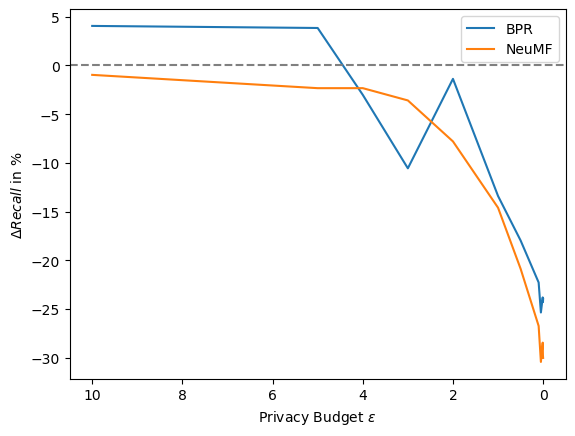

In [152]:
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
plt.plot(all_eps, delta_recall["BPR"], label="BPR")
plt.plot(all_eps, delta_recall["NeuMF"], label="NeuMF")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta Recall$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

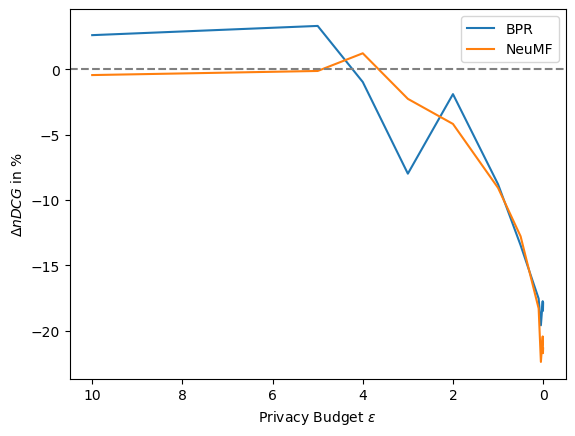

In [153]:
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
plt.plot(all_eps, delta_ndcg["BPR"], label="BPR")
plt.plot(all_eps, delta_ndcg["NeuMF"], label="NeuMF")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta nDCG$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

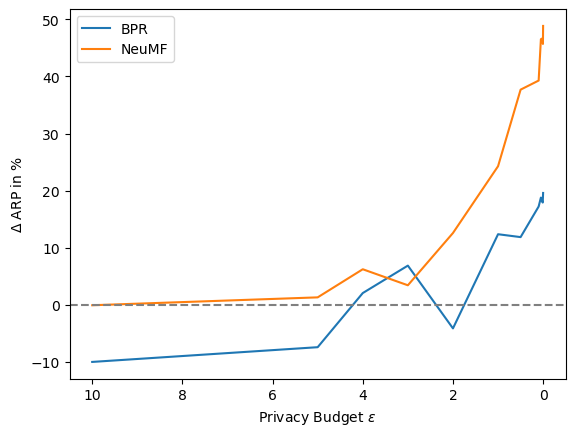

In [154]:
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
plt.plot(all_eps, delta_arp["BPR"], label="BPR")
plt.plot(all_eps, delta_arp["NeuMF"], label="NeuMF")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ ARP in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

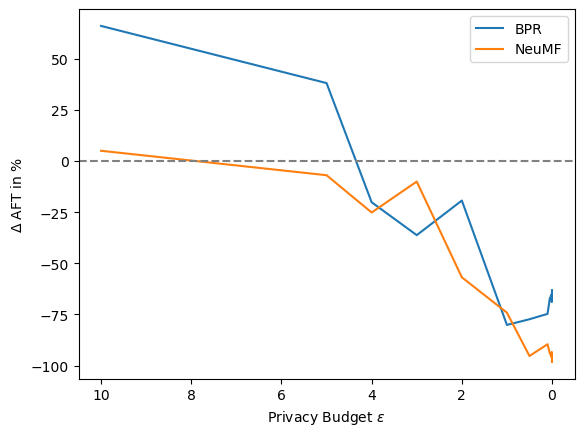

In [155]:
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
plt.plot(all_eps, delta_aft["BPR"], label="BPR")
plt.plot(all_eps, delta_aft["NeuMF"], label="NeuMF")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ AFT in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

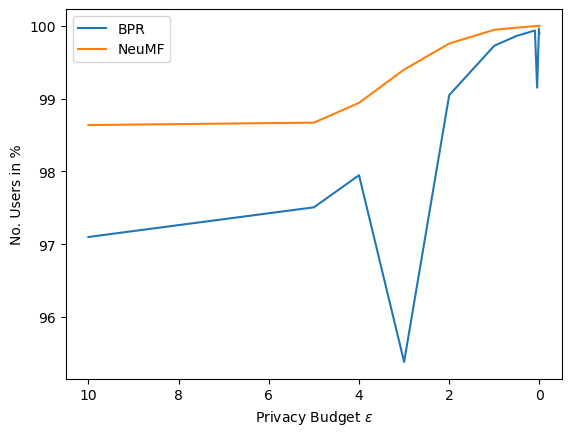

In [156]:
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
plt.plot(all_eps, no_users["BPR"], label="BPR")
plt.plot(all_eps, no_users["NeuMF"], label="NeuMF")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("No. Users in %")
plt.gca().invert_xaxis()
plt.legend()

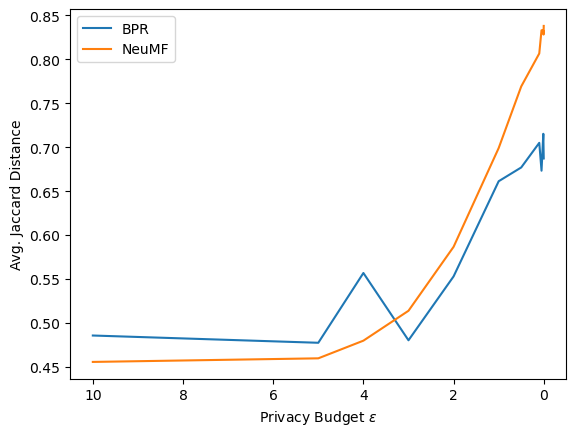

In [157]:
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
plt.plot(all_eps, jacc_dist["BPR"], label="BPR")
plt.plot(all_eps, jacc_dist["NeuMF"], label="NeuMF")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("Avg. Jaccard Distance")
plt.gca().invert_xaxis()
plt.legend()